In [118]:
import os
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt

# custom
from data_utilities import *

directory = 'D:\\racunalni_vid\dataset-verse19test\dataset-verse19test\derivatives\sub-verse054'

# Step 4: Load files for a single data sample
img_nib = nib.load(os.path.join(directory, 'sub-verse054_ct.nii.gz'))
msk_nib = nib.load(os.path.join(directory, 'sub-verse054_seg-vert_msk.nii.gz'))
ctd_list = load_centroids(os.path.join(directory, 'sub-verse054_seg-subreg_ctd.json'))


In [119]:
#check img zooms 
zooms = img_nib.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_nib.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('Centroid List: {}'.format(ctd_list))

img zooms = (1.0, 1.0, 2.0)
img orientation code: ('P', 'I', 'R')
Centroid List: [('P', 'I', 'R'), [20, 95.1, 32.8, 26.4], [21, 84.8, 59.0, 26.1], [22, 75.1, 88.4, 26.7], [23, 68.6, 119.8, 27.9], [24, 74.6, 150.2, 28.0]]


In [120]:
# Resample and Reorient data
img_iso = resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
msk_iso = resample_nib(msk_nib, voxel_spacing=(1, 1, 1), order=0) # or resample based on img: resample_mask_to(msk_nib, img_iso)
ctd_iso = rescale_centroids(ctd_list, img_nib, (1,1,1))

img_iso = reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
msk_iso = reorient_to(msk_iso, axcodes_to=('I', 'P', 'L'))
ctd_iso = reorient_centroids_to(ctd_iso, img_iso)

#check img zooms 
zooms = img_iso.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_iso.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('new centroids: {}'.format(ctd_iso))

[*] Image resampled to voxel size: (1, 1, 1)
[*] Image resampled to voxel size: (1, 1, 1)
[*] Rescaled centroid coordinates to spacing (x, y, z) = (1, 1, 1) mm
img zooms = (1.0, 1.0, 1.0)
img orientation code: ('I', 'P', 'L')
new centroids: [('I', 'P', 'L'), [20, 32.8, 95.1, 55.2], [21, 59.0, 84.8, 55.8], [22, 88.4, 75.1, 54.6], [23, 119.8, 68.6, 52.2], [24, 150.2, 74.6, 52.0]]


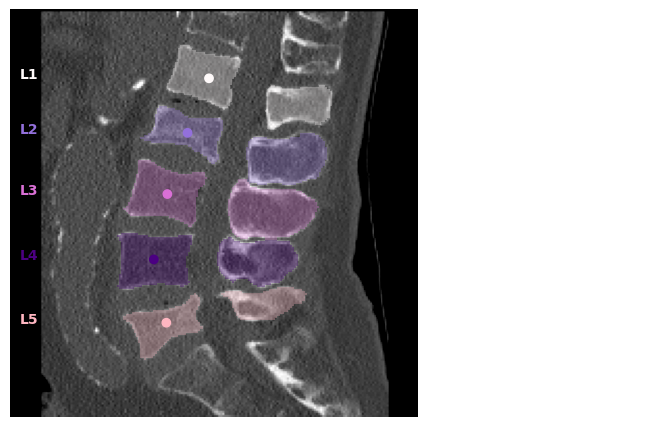

In [178]:
# get vocel data
im_np  = img_iso.get_fdata()
msk_np = msk_iso.get_fdata()

# get the mid-slice of the scan and mask in sagittal plane
im_np_sag = im_np[:,:,int(im_np.shape[2]/2)]
im_np_cor = im_np[:,int(im_np.shape[1]/2),:]

msk_np_sag = msk_np[:,:,int(msk_np.shape[2]/2)]
msk_np_sag[msk_np_sag==0] = np.nan

msk_np_cor = msk_np[:,int(msk_np.shape[1]/2),:]
msk_np_cor[msk_np_cor==0] = np.nan


# plot 
fig, axs = create_figure(96,im_np_sag, im_np_cor)

axs[0].imshow(im_np_sag, cmap=plt.cm.gray, norm=wdw_sbone)
axs[0].imshow(msk_np_sag, cmap=cm_itk, alpha=0.3, vmin=1, vmax=64)
plot_sag_centroids(axs[0], ctd_iso, zooms)



C:\Users\Moj STROJ\AppData\Roaming\Python\Python311\site-packages\skimage\measure\_label.py:120: RuntimeWarning: invalid value encountered in cast
  return clabel(label_image, background, return_num, connectivity)


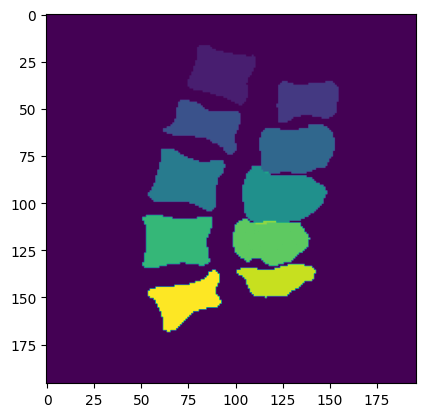

In [122]:
plt.imshow(msk_np_sag)
import skimage

labeled = skimage.measure.label(msk_np_sag)
plt.imshow(labeled)


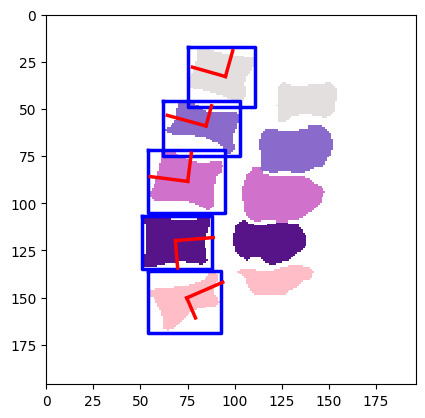

In [174]:
# Plot the original image
plt.imshow(msk_np_sag, cmap='grey')

# Set the axis limits to match the dimensions of the image
plt.xlim(0, msk_np_sag.shape[1])
plt.ylim(msk_np_sag.shape[0], 0)  # Invert y-axis to match image coordinates

# Measure region properties
regions = skimage.measure.regionprops(labeled)

# Get the areas of all regions
areas = [props.area for props in regions]

# Find the index of the largest region
largest_region_index = np.argmax(areas)

# Initialize an empty list to store matching bounding boxes
matching_bounding_boxes = []

# Loop through each region
for props in regions:
    # Exclude the largest region
    if props.label != largest_region_index + 1:
        # Get bounding box coordinates for the current region
        minr, minc, maxr, maxc = props.bbox
        
        # Initialize a flag to check if centroid is found in the current region
        centroid_found = False
        
        # Loop through centroids in ctd_iso and check if any falls within the current region
        for centroid in ctd_iso[1:]:
            centroid_x, centroid_y = centroid[2], centroid[1]
            if minc <= centroid_x <= maxc and minr <= centroid_y <= maxr:
                # Centroid is inside the region, set the flag and break the loop
                centroid_found = True
                break
        
        # If centroid is found, draw the bounding box and axes
        if centroid_found:
            # Draw the bounding box only for regions with centroids
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            plt.plot(bx, by, '-b', linewidth=2.5)
            
            # Get centroid and orientation
            y0, x0 = centroid[1], centroid[2]
            orientation = props.orientation
            
            # Calculate endpoints for major and minor axes
            x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
            y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
            x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
            y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length
            
            # Draw major and minor axes
            plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)

            # Append the bounding box coordinates to the list
            matching_bounding_boxes.append((minr, minc, maxr, maxc))

# Convert the list of bounding boxes to a numpy array for easy manipulation
matching_bounding_boxes = np.array(matching_bounding_boxes)
plt.imshow(msk_np_sag, cmap=cm_itk, alpha=0.9, vmin=1, vmax=64)

plt.show()


In [177]:
import numpy as np

# Assuming you have extracted major axes for each vertebra and stored them in a list
major_axes = [...]  # List of major axes for each vertebra

# Define a function to calculate the angle between two vectors
def angle_between(v1, v2):
    """Calculate the angle in radians between two vectors."""
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(dot_product / norm_product)

# Initialize variables to store the largest angle and the corresponding vertebra indices
largest_angle = 0
largest_angle_indices = None

# Loop through each pair of major axes and calculate the angle between them
for i in range(len(major_axes)):
    for j in range(i+1, len(major_axes)):
        angle = angle_between(major_axes[i], major_axes[j])
        if angle > largest_angle:
            largest_angle = angle
            largest_angle_indices = (i, j)

# Print the largest angle and its corresponding vertebra indices
print("Largest Angle:", np.degrees(largest_angle))
print("Corresponding Vertebra Indices:", largest_angle_indices)


Largest Angle: 0.0
Corresponding Vertebra Indices: None


AttributeError: 'CompositeGenericTransform' object has no attribute 'rotate_deg_around'

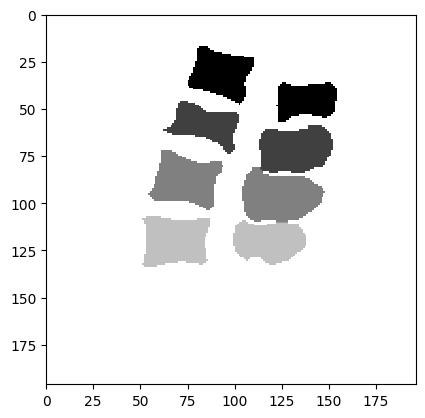

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.measure

# Function to create a rotated rectangle
def create_rotated_rectangle(center, width, height, angle):
    rectangle = patches.Rectangle((0, 0), width, height, edgecolor='blue', facecolor='none')
    rectangle.set_transform(
        plt.gca().transData.rotate_deg_around(center[0], center[1], np.degrees(-angle)))
    return rectangle

# Plot the original image
plt.imshow(msk_np_sag, cmap='gray')

# Set the axis limits to match the dimensions of the image
plt.xlim(0, msk_np_sag.shape[1])
plt.ylim(msk_np_sag.shape[0], 0)  # Invert y-axis to match image coordinates

# Measure region properties
regions = skimage.measure.regionprops(labeled)

# Loop through each region
for props in regions:
    # Get bounding box coordinates for the current region
    minr, minc, maxr, maxc = props.bbox

    # Get the centroid coordinates
    centroid_y, centroid_x = props.centroid

    # Calculate the width and height of the rectangle
    width = maxc - minc
    height = maxr - minr

    # Create the rotated rectangle
    rectangle = create_rotated_rectangle((centroid_x, centroid_y), width, height, props.orientation)

    # Add the rectangle to the plot
    plt.gca().add_patch(rectangle)

plt.show()


Largest Angle: 175.46919499303903


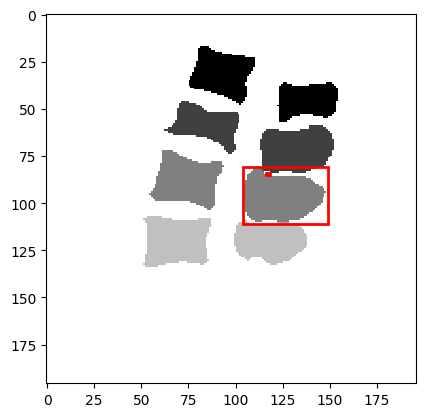

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate the angle between two vectors
def angle_between(v1, v2):
    """Calculate the angle in radians between two vectors."""
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(dot_product / norm_product)

# Define a function to calculate the angle of rotation of a vector
def rotation_angle(v):
    """Calculate the angle of rotation in radians of a vector."""
    return np.arctan2(v[1], v[0])

# Initialize a list to store the axis direction and rotation angle for each vertebra
axis_directions = []
rotation_angles = []

# Loop through each region
for props in regions:
    # Exclude the largest region
    if props.label != largest_region_index + 1:
        # Get orientation of the region
        orientation = props.orientation
        
        # Calculate major axis direction
        axis = np.array([np.cos(orientation), -np.sin(orientation)])
        
        # Calculate the rotation angle of the axis
        angle = rotation_angle(axis)
        
        # Save the axis direction and rotation angle
        axis_directions.append(axis)
        rotation_angles.append(angle)

# Initialize lists to store information about the vertebra with the largest angle
largest_angle_vertices = []
largest_angle_index = None
largest_angle = 0

# Loop through each vertebra again to compare with the reference vertebra
for i, reference_axis in enumerate(axis_directions):
    # Loop through each vertebra again to compare with the reference vertebra
    for j, axis in enumerate(axis_directions):
        if i != j:  # Skip comparing with itself
            # Calculate the angle between the two axes
            angle = angle_between(reference_axis, axis)
            
            # Update the largest angle and index if the current angle is larger
            if angle > largest_angle:
                largest_angle = angle
                largest_angle_index = j
                largest_angle_vertices = [i, j]

# Print the largest angle and its corresponding vertebra index for the reference vertebra
print(f"Largest Angle: {np.degrees(largest_angle)}")

# Plot the original image
plt.imshow(msk_np_sag, cmap='gray')

# Plot the vertebrae with the largest angle
for vertex_index in largest_angle_vertices:
    props = regions[vertex_index]
    minr, minc, maxr, maxc = props.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)

# Show the plot
plt.show()


Cobb's Angle: 1.5911402711945872
Cobb's Angle: 1.3971810272963765
Cobb's Angle: 1.3971810272963765
Cobb's Angle: -1.5481576989779677
Cobb's Angle: -1.4688007143858246


C:\Users\Moj STROJ\AppData\Local\Temp\ipykernel_15924\2929702641.py:70: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


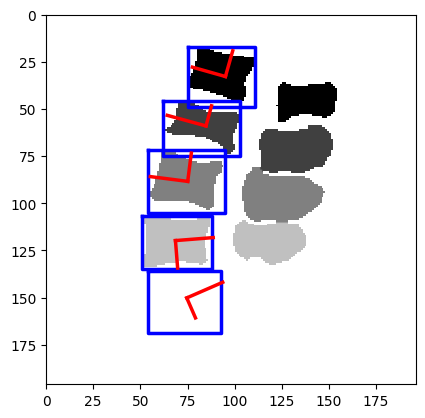

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure
import cv2

# Plot the original image
plt.imshow(msk_np_sag, cmap='grey')

# Set the axis limits to match the dimensions of the image
plt.xlim(0, msk_np_sag.shape[1])
plt.ylim(msk_np_sag.shape[0], 0)  # Invert y-axis to match image coordinates

# Measure region properties
regions = skimage.measure.regionprops(labeled)

# Get the areas of all regions
areas = [props.area for props in regions]

# Find the index of the largest region
largest_region_index = np.argmax(areas)

# Initialize an empty list to store matching bounding boxes
matching_bounding_boxes = []

# Loop through each region
for props in regions:
    # Exclude the largest region
    if props.label != largest_region_index + 1:
        # Get bounding box coordinates for the current region
        minr, minc, maxr, maxc = props.bbox
        
        # Initialize a flag to check if centroid is found in the current region
        centroid_found = False
        
        # Loop through centroids in ctd_iso and check if any falls within the current region
        for centroid in ctd_iso[1:]:
            centroid_x, centroid_y = centroid[2], centroid[1]
            if minc <= centroid_x <= maxc and minr <= centroid_y <= maxr:
                # Centroid is inside the region, set the flag and break the loop
                centroid_found = True
                break
        
        # If centroid is found, draw the bounding box and axes
        if centroid_found:
            # Draw the bounding box only for regions with centroids
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            plt.plot(bx, by, '-b', linewidth=2.5)
            
            # Get centroid and orientation
            y0, x0 = centroid[1], centroid[2]
            orientation = props.orientation
            
            # Calculate endpoints for major and minor axes
            x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
            y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
            x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
            y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length
            
            # Draw major and minor axes
            plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)

            # Append the bounding box coordinates to the list
            matching_bounding_boxes.append((minr, minc, maxr, maxc))

            # Calculate Cobb's angle using major axis angle
            rect = ((minc + maxc) / 2, (minr + maxr) / 2), (maxc - minc, maxr - minr), orientation
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            # Get major axis endpoints
            (x0, y0), (x1, y1), (x2, y2), _ = box

            # Calculate Cobb's angle using major axis
            cobb_angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))

            # Display Cobb's angle
            print("Cobb's Angle:", cobb_angle)

# Convert the list of bounding boxes to a numpy array for easy manipulation
matching_bounding_boxes = np.array(matching_bounding_boxes)

plt.show()


C:\Users\Moj STROJ\AppData\Local\Temp\ipykernel_15924\3448401353.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  intersection_x = (lower_end_y - upper_end_y + perpendicular_slope_upper * upper_end_x - perpendicular_slope_lower * lower_end_x) / (perpendicular_slope_upper - perpendicular_slope_lower)
C:\Users\Moj STROJ\AppData\Local\Temp\ipykernel_15924\3448401353.py:80: RuntimeWarning: invalid value encountered in scalar divide
  cobb_angle = np.degrees(np.arctan((lower_end_y - intersection_y) / (lower_end_x - intersection_x)) - np.arctan((upper_end_y - intersection_y) / (upper_end_x - intersection_x)))


Cobb's Angle: nan


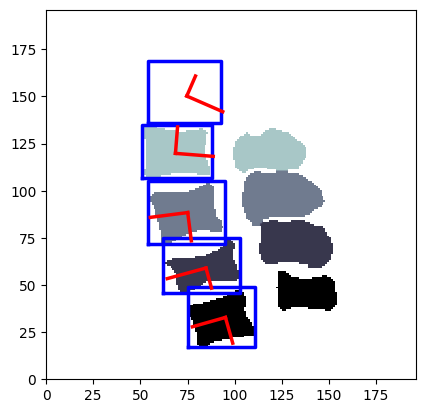

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure

# Plot the original image
plt.imshow(msk_np_sag, cmap='bone')

# Set the axis limits to match the dimensions of the image
plt.xlim(0, msk_np_sag.shape[1])
plt.ylim(0, msk_np_sag.shape[0]) 

# Measure region properties
regions = skimage.measure.regionprops(labeled)

# Get the areas of all regions
areas = [props.area for props in regions]

# Find the index of the largest region
largest_region_index = np.argmax(areas)

# Initialize an empty list to store matching bounding boxes
matching_bounding_boxes = []

# Loop through each region
for props in regions:
    # Exclude the largest region
    if props.label != largest_region_index + 1:
        # Get bounding box coordinates for the current region
        minr, minc, maxr, maxc = props.bbox
        
        # Initialize a flag to check if centroid is found in the current region
        centroid_found = False
        
        # Loop through centroids in ctd_iso and check if any falls within the current region
        for centroid in ctd_iso[1:]:
            centroid_x, centroid_y = centroid[2], centroid[1]
            if minc <= centroid_x <= maxc and minr <= centroid_y <= maxr:
                # Centroid is inside the region, set the flag and break the loop
                centroid_found = True
                break
        
        # If centroid is found, draw the bounding box and axes
        if centroid_found:
            # Draw the bounding box only for regions with centroids
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            plt.plot(bx, by, '-b', linewidth=2.5)
            
            # Get centroid and orientation
            y0, x0 = centroid[1], centroid[2]
            orientation = props.orientation
            
            # Calculate endpoints for major and minor axes
            x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
            y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
            x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
            y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length
            
            # Draw major and minor axes
            plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)

            # Append the bounding box coordinates to the list
            matching_bounding_boxes.append((minr, minc, maxr, maxc))

# Convert the list of bounding boxes to a numpy array for easy manipulation
matching_bounding_boxes = np.array(matching_bounding_boxes)

# Define upper and lower end vertebra centroid coordinates (replace with actual values)
upper_end_centroid_x, upper_end_centroid_y = 100, 100
lower_end_centroid_x, lower_end_centroid_y = 200, 200

# Calculate Cobb's angle if slopes are not zero
if perpendicular_slope_upper != 0 and perpendicular_slope_lower != 0:
    # Calculate the intersection point of the lines
    intersection_x = (lower_end_y - upper_end_y + perpendicular_slope_upper * upper_end_x - perpendicular_slope_lower * lower_end_x) / (perpendicular_slope_upper - perpendicular_slope_lower)
    intersection_y = upper_end_y + perpendicular_slope_upper * (intersection_x - upper_end_x)

    # Calculate Cobb's angle using the arctangent function
    cobb_angle = np.degrees(np.arctan((lower_end_y - intersection_y) / (lower_end_x - intersection_x)) - np.arctan((upper_end_y - intersection_y) / (upper_end_x - intersection_x)))

    # Display Cobb's angle
    print("Cobb's Angle:", cobb_angle)
else:
    print("Slopes are zero, unable to calculate Cobb's angle")

# Display the image with drawn bounding boxes and axes
plt.show()


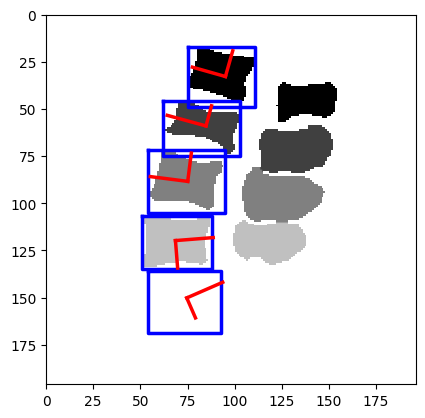

In [123]:
# Plot the original image
plt.imshow(msk_np_sag, cmap='gray')

# Set the axis limits to match the dimensions of the image
plt.xlim(0, msk_np_sag.shape[1])
plt.ylim(msk_np_sag.shape[0], 0)  # Invert y-axis to match image coordinates

# Measure region properties
regions = skimage.measure.regionprops(labeled)

# Get the areas of all regions
areas = [props.area for props in regions]

# Find the index of the largest region
largest_region_index = np.argmax(areas)

# Initialize an empty list to store matching bounding boxes
matching_bounding_boxes = []

# Loop through each region
for props in regions:
    # Exclude the largest region
    if props.label != largest_region_index + 1:
        # Get bounding box coordinates for the current region
        minr, minc, maxr, maxc = props.bbox
        
        # Initialize a flag to check if centroid is found in the current region
        centroid_found = False
        
        # Loop through centroids in ctd_iso and check if any falls within the current region
        for centroid in ctd_iso[1:]:
            centroid_x, centroid_y = centroid[2], centroid[1]
            if minc <= centroid_x <= maxc and minr <= centroid_y <= maxr:
                # Centroid is inside the region, set the flag and break the loop
                centroid_found = True
                break
        
        # If centroid is found, draw the bounding box and axes
        if centroid_found:
            # Draw the bounding box only for regions with centroids
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            plt.plot(bx, by, '-b', linewidth=2.5)
            
            # Get centroid and orientation
            y0, x0 = centroid[1], centroid[2]
            orientation = props.orientation
            
            # Calculate endpoints for major and minor axes
            x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
            y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
            x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
            y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length
            
            # Draw major and minor axes
            plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)

            # Append the bounding box coordinates to the list
            matching_bounding_boxes.append((minr, minc, maxr, maxc))

# Convert the list of bounding boxes to a numpy array for easy manipulation
matching_bounding_boxes = np.array(matching_bounding_boxes)

plt.show()


centroid location: 96.38164141985078 98.86557281741545
centroid location: 92.83244680851064 31.75531914893617
centroid location: 137.81034482758622 45.793103448275865
centroid location: 84.38401253918495 58.70219435736677
centroid location: 132.08755760368663 71.70852534562212
centroid location: 74.00582750582751 88.14918414918415
centroid location: 123.66632962588473 96.79069767441861
centroid location: 116.5 84.0
centroid location: 68.53517877739331 120.24682814302192
centroid location: 118.0 120.57180500658761
centroid location: 115.92307692307692 110.46153846153847
centroid location: 121.78615071283096 140.68635437881875
centroid location: 73.56896551724138 151.47492163009403


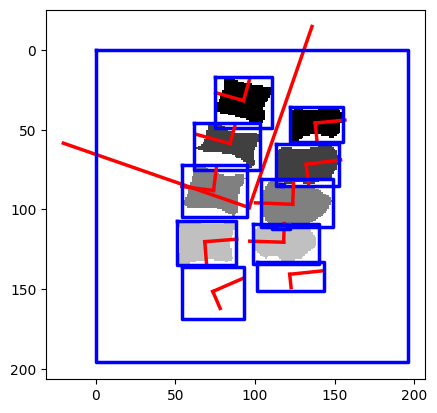

In [124]:
regions = skimage.measure.regionprops(labeled)

# Plot the original image
plt.imshow(msk_np_sag, cmap='gray')

# Loop through each region
for props in regions:
    # Get centroid and orientation
    y0, x0 = props.centroid
    print("centroid location:",x0,y0)
    orientation = props.orientation
    # Calculate endpoints for major and minor axes
    x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length
    
    # Draw major and minor axes
    plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    
    # # Draw centroid
    #plt.plot(x0, y0, '.g', markersize=15)
    
    # # Draw bounding box
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    plt.plot(bx, by, '-b', linewidth=2.5)

# plt.show()

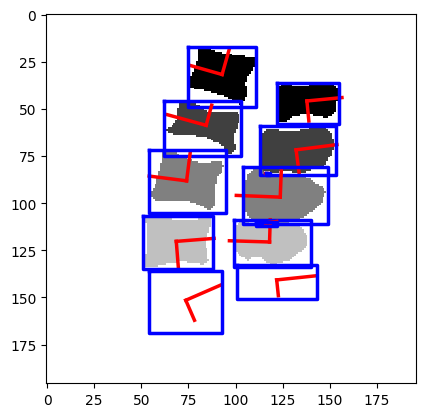

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure

# Assuming 'labeled' is your labeled array obtained from skimage.measure.label

# Measure region properties
regions = skimage.measure.regionprops(labeled)

# Plot the original image
plt.imshow(msk_np_sag, cmap='gray')

# Get the areas of all regions
areas = [props.area for props in regions]

# Find the index of the largest region
largest_region_index = np.argmax(areas)

# Loop through each region
for idx, props in enumerate(regions):
    # Exclude the largest region
    if idx != largest_region_index:
        # Get centroid and orientation
        y0, x0 = props.centroid
        orientation = props.orientation
        
        # Calculate endpoints for major and minor axes
        x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
        y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
        x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
        y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length
        
        # Draw major and minor axes
        plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        
        # Draw bounding box
        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        plt.plot(bx, by, '-b', linewidth=2.5)

plt.show()


[20, 32.8, 95.1, 55.2]
[20, 32.8, 95.1, 55.2]
[21, 59.0, 84.8, 55.8]
[21, 59.0, 84.8, 55.8]
[22, 88.4, 75.1, 54.6]
[22, 88.4, 75.1, 54.6]
[21, 59.0, 84.8, 55.8]
[23, 119.8, 68.6, 52.2]
[23, 119.8, 68.6, 52.2]
[22, 88.4, 75.1, 54.6]
[24, 150.2, 74.6, 52.0]
[24, 150.2, 74.6, 52.0]


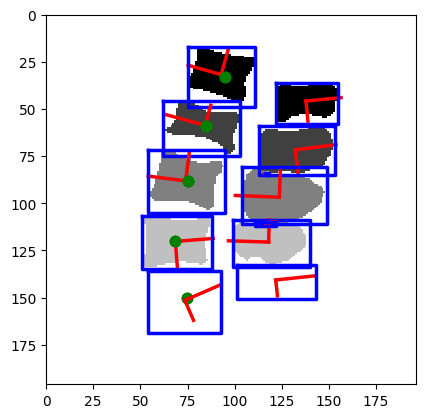

In [126]:
# Plot the original image
plt.imshow(msk_np_sag, cmap='gray')

# Set the axis limits to match the dimensions of the image
plt.xlim(0, msk_np_sag.shape[1])
plt.ylim(msk_np_sag.shape[0], 0)  # Invert y-axis to match image coordinates

# Measure region properties
regions = skimage.measure.regionprops(labeled)

# Get the areas of all regions
areas = [props.area for props in regions]

# Find the index of the largest region
largest_region_index = np.argmax(areas)

# Initialize an empty list to store matching bounding boxes
matching_bounding_boxes = []

# Loop through each region
for idx, props in enumerate(regions):
    # Exclude the largest region
    if idx != largest_region_index:
        # Get centroid and orientation
        y0, x0 = props.centroid
        orientation = props.orientation

        # Initialize variables for minimum distance and the corresponding centroid index
        min_distance = float('inf')
        closest_centroid_index = None

        # Loop through centroids in ctd_iso and find the closest one to the region's centroid
        for idx, centroid in enumerate(ctd_iso[1:]):
            distance = np.sqrt((x0 - centroid[2]) ** 2 + (y0 - centroid[1]) ** 2)
            if distance < min_distance:
                min_distance = distance
                closest_centroid_index = idx

        # Check if a closest centroid was found and if it's not None
        if closest_centroid_index is not None:
            # Get the closest centroid from ctd_iso
            closest_centroid = ctd_iso[closest_centroid_index + 1]
            print(closest_centroid)
            closest_x, closest_y = closest_centroid[2], closest_centroid[1]

            # Plot the centroid
            plt.plot(closest_x, closest_y, '.g', markersize=15)

            # Calculate endpoints for major and minor axes
            x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
            y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
            x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
            y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length

            # Draw major and minor axes
            plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)

            # Draw bounding box
            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            plt.plot(bx, by, '-b', linewidth=2.5)

            # Append the bounding box coordinates to the list if the centroid matches
            matching_bounding_boxes.append((minr, minc, maxr, maxc))

# Convert the list of bounding boxes to a numpy array for easy manipulation
matching_bounding_boxes = np.array(matching_bounding_boxes)

plt.show()

Prepoznavanje kraljezaka, ali trenutno osim trupa kraljeska prepoznaje i poprecni i trnasti nastavak.x